### Mesh 추출 (Mediapipe 필요)

In /home/gaudio/anaconda3/envs/ste/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/gaudio/anaconda3/envs/ste/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/gaudio/anaconda3/envs/ste/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/gaudio/anaconda3/envs/ste/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/gaudio/anaconda

/data/sd_dataset/celeba/0.jpg


I0000 00:00:1720342592.736794 3658302 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342592.810344 3658518 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/home/gaudio/anaconda3/envs/ste/lib/python3.8/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


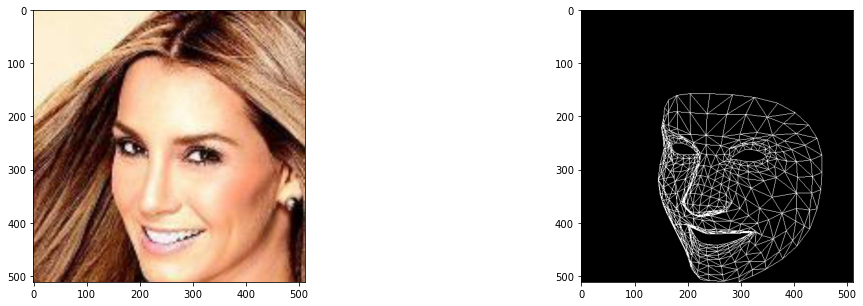

/data/sd_dataset/celeba/1.jpg


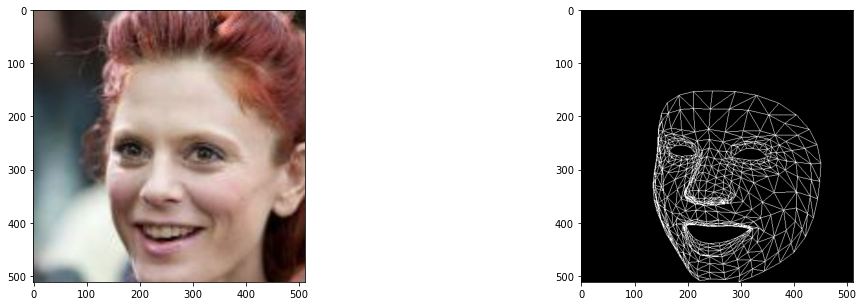

In [1]:
# reference : https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/face_mesh.md
    
import cv2
import mediapipe as mp
import numpy as np
import os
import matplotlib.pyplot as plt

# Initialize MediaPipe Face Mesh.
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

# Define the list of image files to process.
image_dir = '/data/sd_dataset/celeba'
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
image_files = sorted(image_files)
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

# Create a FaceMesh object.
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5) as face_mesh:
  
  # Iterate over each image file.
  for idx, file in enumerate(image_files[:2]):
    print(file)
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Convert the BGR image to RGB before processing.
    results = face_mesh.process(image)

    # If no face landmarks are detected, continue to the next image.
    if not results.multi_face_landmarks:
      continue

    # Create a copy of the image to draw the annotations on.
    h, w, _ = image.shape
    annotated_image = np.zeros((h, w, 3), dtype=np.uint8)
    
    # Draw the face mesh landmarks on the image.
    for face_landmarks in results.multi_face_landmarks:
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_TESSELATION,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1))
    
    plt.figure(figsize=[18, 5])
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(annotated_image)
    plt.show()




### Mesh 파일 저장하기

In [ ]:
import os
import cv2
import mediapipe as mp
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import shutil
from tqdm import tqdm

# Initialize MediaPipe Face Mesh.
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

# Define the list of image files to process.
image_dir = '/data/sd_dataset/celeba'
source_dir = '/data/sd_dataset/celeba_controlnet/images'
target_dir = '/data/sd_dataset/celeba_controlnet/conditioning_images'
os.makedirs(source_dir, exist_ok=True)  # Create the source directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)  # Create the target directory if it doesn't exist

image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
image_files = sorted(image_files)
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

# Define a function to process each image.
def process_image(file):
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:
        
        image_bgr = cv2.imread(file)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        
        # Convert the BGR image to RGB before processing.
        results = face_mesh.process(image_rgb)

        # If no face landmarks are detected, continue to the next image.
        if not results.multi_face_landmarks:
            return

        # Create a copy of the image to draw the annotations on.
        h, w, _ = image_rgb.shape
        annotated_image = np.zeros((h, w, 3), dtype=np.uint8)

        # Draw the face mesh landmarks on the image.
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=annotated_image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 255, 255), thickness=1))

        # Save the annotated image to the target directory.
        annotated_image_bgr = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
        source_file = os.path.join(source_dir, os.path.basename(file))
        target_file = os.path.join(target_dir, os.path.basename(file))
        cv2.imwrite(target_file, annotated_image_bgr)
        
        # Copy Original Image and Text Caption File
        shutil.copy(file, os.path.join(source_dir, os.path.basename(file)))
        txt_file = file[:-3] + "txt"
        shutil.copy(txt_file, os.path.join(source_dir, os.path.basename(txt_file)))

# Number of threads to use for parallel processing.
num_threads = 64

# Use ThreadPoolExecutor to process images in parallel.
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    # Submit tasks to the executor and display progress with tqdm.
    list(tqdm(executor.map(process_image, image_files), total=len(image_files)))


I0000 00:00:1720342597.099887 3658617 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342597.132815 3658672 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342597.156462 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342597.178016 3658780 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342597.179854 3658618 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342597.201772 3658782 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342597.215741 3658781 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342597.235906 3658837 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342598.934274 3660708 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342598.956350 3660815 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342598.970448 3660653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342598.993213 3660816 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342599.076435 3660817 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342599.098232 3660925 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342599.122167 3660818 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342599.142643 3660927 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342601.219620 3662461 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342601.405902 3658781 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342601.426308 3662515 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342601.551529 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342601.572570 3662569 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342601.603220 3659992 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342601.623214 3662623 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342601.709783 3658836 gl_context_egl.cc:85] Successfu

  0%|                                                                  | 11/10000 [00:03<48:11,  3.46it/s]I0000 00:00:1720342604.136634 3660320 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342604.157292 3664405 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342604.180092 3659607 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342604.201094 3664459 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342604.317972 3661203 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342604.339407 3664513 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
  0%|                                                                  | 12/10000 [00:03<48:45,  3.41it/s]I0000 00

I0000 00:00:1720342606.803480 3660266 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342606.825719 3666133 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
  0%|▎                                                                 | 48/10000 [00:05<25:18,  6.55it/s]I0000 00:00:1720342606.935431 3661202 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342606.956499 3666240 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342606.969554 3662080 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342606.993575 3666241 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342607.045981 3659000 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342609.569368 3659333 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342609.589842 3668139 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342609.724857 3660653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342609.745988 3668193 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342609.771223 3660212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342609.792504 3668247 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342609.902159 3661860 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342609.922739 3668301 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

  1%|▋                                                                | 105/10000 [00:13<41:04,  4.01it/s]I0000 00:00:1720342614.627905 3671433 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342614.763966 3660818 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342614.784110 3671540 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342614.821352 3660598 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342614.842089 3671594 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342614.845872 3660708 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342614.868199 3671595 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

I0000 00:00:1720342617.505416 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342617.526925 3673432 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
  2%|█▏                                                               | 184/10000 [00:16<32:51,  4.98it/s]I0000 00:00:1720342617.656932 3660928 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342617.678344 3673486 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342617.762977 3661091 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342617.782329 3673593 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342617.783698 3661257 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

  2%|█▍                                                               | 221/10000 [00:18<22:33,  7.23it/s]I0000 00:00:1720342619.882727 3661476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342619.902886 3675053 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342619.945178 3661037 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342619.966089 3675107 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342620.065967 3659387 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342620.086829 3675161 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342620.171295 3661971 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342622.835236 3658617 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  3%|█▋                                                               | 260/10000 [00:21<13:44, 11.81it/s]I0000 00:00:1720342622.855367 3676834 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342622.894643 3659607 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342622.916541 3676888 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342622.930350 3661258 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342622.948795 3676942 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342622.957707 3659606 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342625.821730 3661259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342625.842976 3678941 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342625.864698 3660103 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342625.885536 3678995 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342625.971979 3659992 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342625.990869 3679049 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342626.074205 3661533 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342626.095962 3679156 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342628.463204 3660653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342628.485162 3680669 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342628.594594 3661971 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  3%|██▏                                                              | 329/10000 [00:27<13:15, 12.15it/s]I0000 00:00:1720342628.615696 3680776 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342628.640106 3659112 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342628.660748 3680777 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
  3%|██▏                                                              | 332/10000 [00:27<11:08, 14.47it/s]I0000 00

I0000 00:00:1720342631.270148 3660487 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342631.291405 3682666 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342631.296310 3658836 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342631.317101 3682667 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
  3%|██▏                                                              | 346/10000 [00:30<28:11,  5.71it/s]I0000 00:00:1720342631.429476 3660928 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342631.451285 3682721 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
  3%|██▎                                                              | 348/10000 [00:30<23:05,  6.96it/s]I0000 00

  4%|██▌                                                              | 387/10000 [00:32<18:15,  8.78it/s]erer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342633.768831 3660489 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342633.789887 3684287 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342633.884592 3660212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342633.906053 3684341 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
  4%|██▌                                                              | 389/10000 [00:33<20:26,  7.84it/s]I0000 00:00:1720342634.168868 3659000 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342634.189577 3684395 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NV

I0000 00:00:1720342636.624247 3660103 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342636.645749 3686067 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342636.691138 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342636.711746 3686121 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342636.712995 3659497 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342636.736600 3686122 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342636.779582 3658781 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342636.798754 3686229 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

  5%|██▉                                                              | 451/10000 [00:38<27:03,  5.88it/s]I0000 00:00:1720342638.904165 3687588 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342638.981615 3660433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342639.004075 3687695 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342639.016179 3662080 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342639.037601 3687749 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342639.132042 3658893 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342639.152394 3687803 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

I0000 00:00:1720342641.264918 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342641.287479 3689263 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342641.544871 3660433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342641.566699 3689317 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342641.613670 3661203 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342641.635597 3689371 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342641.658007 3661257 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342641.679849 3689425 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342644.191918 3691153 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342644.209633 3661971 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342644.231088 3691207 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342644.269428 3659223 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342644.292516 3691261 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342644.356574 3659113 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342644.376759 3691315 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342644.418028 3659221 gl_context_egl.cc:85] Successfu

  6%|███▋                                                             | 563/10000 [00:47<48:33,  3.24it/s]I0000 00:00:1720342649.165229 3660489 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342649.186597 3694499 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342649.209600 3659387 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342649.235103 3694500 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342649.258971 3661697 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  6%|███▋                                                             | 565/10000 [00:48<40:18,  3.90it/s]I0000 00:00:1720342649.279923 3694554 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00

I0000 00:00:1720342654.050815 3660320 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342654.069576 3697687 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342654.116681 3661805 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342654.137741 3697741 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
  6%|████                                                             | 628/10000 [00:53<17:43,  8.81it/s]I0000 00:00:1720342654.189831 3660433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342654.211166 3697795 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
  6%|████▏                                                            | 636/10000 [00:53<13:15, 11.77it/s]I0000 00

I0000 00:00:1720342656.468969 3699307 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
  6%|████▏                                                            | 649/10000 [00:55<18:09,  8.59it/s]I0000 00:00:1720342656.573883 3660321 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342656.597354 3699361 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
  7%|████▏                                                            | 651/10000 [00:55<19:31,  7.98it/s]I0000 00:00:1720342656.730780 3659331 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342656.753357 3699415 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342656.866828 3659387 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00

I0000 00:00:1720342659.142545 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  7%|████▍                                                            | 687/10000 [00:58<20:28,  7.58it/s]I0000 00:00:1720342659.162878 3701035 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342659.189998 3660321 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342659.211741 3701089 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342659.240314 3660103 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342659.261973 3701143 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342659.352062 3661476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

  7%|████▋                                                            | 719/10000 [01:00<22:19,  6.93it/s]I0000 00:00:1720342661.680284 3659882 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342661.700361 3702709 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342661.866051 3659331 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342661.888087 3702763 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342661.999553 3658838 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  7%|████▋                                                            | 728/10000 [01:00<17:48,  8.68it/s]I0000 00:00:1720342662.021810 3702870 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00

I0000 00:00:1720342664.134752 3661259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342664.156660 3704328 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342664.166918 3659607 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342664.189714 3704329 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
  8%|█████                                                            | 774/10000 [01:03<12:33, 12.25it/s]I0000 00:00:1720342664.433983 3704436 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342664.450388 3660212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342664.472151 3704490 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

I0000 00:00:1720342666.765507 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342666.786594 3706056 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342666.803453 3659992 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342666.826137 3706057 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342666.925090 3661257 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342666.944138 3706111 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342667.011331 3659497 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342667.030985 3706218 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

  8%|█████▍                                                           | 827/10000 [01:08<13:19, 11.47it/s]I0000 00:00:1720342669.386411 3658836 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342669.407941 3707739 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342669.569699 3660818 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  8%|█████▍                                                           | 831/10000 [01:08<13:05, 11.67it/s]I0000 00:00:1720342669.591052 3707793 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342669.643235 3660433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342669.665000 3707847 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00

I0000 00:00:1720342671.911488 3659113 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342671.933065 3709465 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342671.940077 3659387 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342671.960865 3709466 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342671.964129 3659992 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342671.984881 3709467 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342672.075031 3660103 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342672.097266 3709521 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342674.606096 3711033 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342674.711971 3659333 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342674.732241 3711193 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342674.735875 3660487 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342674.757254 3711194 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342674.762543 3660818 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342674.784665 3711195 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
  9%|█████▊                                                          

  9%|██████                                                           | 929/10000 [01:16<11:55, 12.68it/s]I0000 00:00:1720342677.612565 3660266 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342677.634339 3712815 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342677.748298 3660320 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342677.768902 3712869 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342677.967896 3660928 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342677.989750 3712976 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342678.011140 3659331 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

 10%|██████▏                                                          | 961/10000 [01:19<24:27,  6.16it/s]I0000 00:00:1720342680.577141 3658618 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342680.598231 3714543 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342680.665401 3661532 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342680.687761 3714650 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342680.704091 3659113 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342680.722618 3714704 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342680.726518 3660818 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

 10%|██████▎                                                          | 975/10000 [01:22<33:49,  4.45it/s]I0000 00:00:1720342683.517338 3660928 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342683.535964 3716485 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342683.574344 3659718 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342683.594890 3716539 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342683.602114 3661805 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342683.622137 3716540 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342683.623933 3661641 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342686.068702 3661091 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342686.092305 3717945 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342686.234044 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342686.255302 3717999 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342686.351879 3658893 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342686.374033 3718106 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342686.393753 3660817 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 10%|██████▌                                                         | 1025/10000 [01:25<16:55,  8.84it/s]I0000

I0000 00:00:1720342688.823096 3658836 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342688.844921 3719672 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342688.867521 3661202 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342688.888372 3719673 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 10%|██████▋                                                         | 1046/10000 [01:28<22:19,  6.69it/s]I0000 00:00:1720342689.119533 3661476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342689.139070 3719727 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342689.194642 3660321 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342691.606567 3658893 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342691.627535 3721293 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342691.655428 3661532 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342691.675465 3721294 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342691.694470 3661259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342691.714353 3721348 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342691.903167 3659607 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342691.924629 3721402 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342694.429756 3659331 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342694.451992 3722860 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342694.484880 3660266 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342694.502024 3722914 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342694.559945 3660321 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342694.581503 3722968 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 11%|███████                                                         | 1112/10000 [01:33<19:06,  7.75it/s]I0000 00:00:1720342694.681109 3659056 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342699.989532 3659882 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342700.010216 3726269 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342700.011023 3658618 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342700.032194 3726270 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342700.081389 3661093 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342700.102353 3726324 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342700.124704 3661476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342700.145352 3726378 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342702.713320 3660487 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342702.733632 3727890 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342702.749424 3659607 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342702.774288 3727944 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342702.830623 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342702.855885 3727998 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342702.908704 3659606 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342702.934556 3728052 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342705.802326 3659387 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342705.824711 3729564 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342705.875239 3659331 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342705.897185 3729618 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342705.915687 3658618 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342705.937651 3729672 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342705.978901 3659882 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342706.002711 3729726 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342708.434480 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342708.456099 3731291 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342708.468940 3660103 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342708.492548 3731292 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 13%|████████                                                        | 1266/10000 [01:47<27:38,  5.27it/s]I0000 00:00:1720342708.507945 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342708.530374 3731346 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342708.586710 3659000 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342711.243700 3659992 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342711.265647 3732911 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342711.266646 3660487 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342711.288366 3732912 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342711.351209 3658781 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342711.373837 3732966 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342711.478168 3658836 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342711.499874 3733020 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342713.944055 3734586 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342713.981246 3659223 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342714.003186 3734640 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342714.080853 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342714.102436 3734694 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342714.218728 3659717 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342714.240440 3734748 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 13%|████████▍                                                       

 14%|████████▋                                                       | 1354/10000 [01:55<17:49,  8.08it/s]I0000 00:00:1720342716.646026 3660433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342716.666296 3736206 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342716.703325 3659882 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342716.723465 3736260 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342716.785185 3661862 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342716.807257 3736314 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 14%|████████▋                                                       | 1356/10000 [01:55<17:34,  8.19it/s]I0000 00

I0000 00:00:1720342719.429612 3660926 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342719.449279 3737880 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342719.466333 3661860 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342719.485275 3737934 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342719.504728 3661476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342719.524894 3737988 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342719.603779 3659718 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342719.625258 3738042 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 14%|█████████                                                       | 1420/10000 [02:00<17:30,  8.17it/s]I0000 00:00:1720342722.096659 3660818 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342722.116122 3739608 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342722.240170 3660266 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342722.261128 3739662 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342722.335627 3660102 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342722.356654 3739716 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 14%|█████████                                                       | 1425/10000 [02:01<15:39,  9.13it/s]I0000 00

I0000 00:00:1720342724.960531 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342724.982324 3741228 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342725.044793 3659606 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342725.063637 3741282 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342725.090108 3660212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342725.108883 3741337 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342725.166724 3660926 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342725.187153 3741391 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 15%|█████████▌                                                      | 1487/10000 [02:06<18:20,  7.74it/s]I0000 00:00:1720342727.551587 3742857 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342727.630841 3660598 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342727.651581 3742911 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342727.685933 3660431 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342727.708342 3742965 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342727.771663 3661971 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342727.790203 3743019 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

I0000 00:00:1720342730.346159 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342730.366926 3744585 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342730.382446 3659113 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342730.401514 3744639 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 15%|█████████▋                                                      | 1512/10000 [02:09<21:42,  6.52it/s]I0000 00:00:1720342730.530583 3659333 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342730.550844 3744693 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342730.828688 3661259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342733.395785 3661532 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342733.415872 3746313 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342733.428754 3661476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342733.449268 3746367 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342733.474569 3660102 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342733.495998 3746421 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342733.575901 3659221 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342733.596915 3746475 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342735.948834 3660212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342735.970736 3747987 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 16%|██████████                                                      | 1572/10000 [02:15<15:04,  9.31it/s]I0000 00:00:1720342736.145792 3660817 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342736.166121 3748041 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342736.296641 3659113 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342736.317232 3748095 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342736.400891 3658838 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342739.138816 3659882 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342739.161542 3749715 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 16%|██████████▎                                                     | 1615/10000 [02:18<16:11,  8.63it/s]I0000 00:00:1720342739.295223 3659607 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342739.316724 3749769 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342739.412382 3661805 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342739.432497 3749876 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342739.434065 3660926 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342741.778063 3659937 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342741.799436 3751388 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342741.825200 3659000 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342741.845154 3751442 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342741.882722 3661862 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342741.904428 3751443 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342741.922886 3658838 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342741.945391 3751497 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 17%|██████████▊                                                     | 1685/10000 [02:26<30:26,  4.55it/s]I0000 00:00:1720342747.238490 3658781 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342747.260012 3754575 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342747.325673 3659331 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342747.346246 3754629 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342747.476447 3660433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342747.496978 3754736 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342747.498766 3661697 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

 17%|███████████                                                     | 1727/10000 [02:28<17:20,  7.95it/s]I0000 00:00:1720342749.929261 3756141 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342750.030901 3660431 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342750.051914 3756195 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342750.069290 3659607 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342750.089958 3756249 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 17%|███████████                                                     | 1729/10000 [02:29<16:21,  8.43it/s]I0000 00:00:1720342750.236524 3659717 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00

 17%|███████████▏                                                    | 1747/10000 [02:31<19:38,  7.00it/s]I0000 00:00:1720342752.656637 3660102 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342752.677883 3757761 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 17%|███████████▏                                                    | 1748/10000 [02:31<19:01,  7.23it/s]I0000 00:00:1720342752.760386 3661862 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342752.780159 3757815 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342752.885682 3660598 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342752.908188 3757869 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00

I0000 00:00:1720342755.272851 3660212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342755.294827 3759273 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342755.335611 3661860 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342755.356686 3759327 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342755.382419 3661258 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342755.402300 3759381 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342755.497237 3661037 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342755.516912 3759435 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342758.016991 3760901 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342758.070201 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342758.089638 3761008 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342758.091590 3659221 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342758.115200 3761009 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 18%|███████████▌                                                    | 1812/10000 [02:37<13:15, 10.29it/s]I0000 00:00:1720342758.246782 3659992 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342758.269754 3761063 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

I0000 00:00:1720342760.898934 3661641 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342760.920532 3762683 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342760.921620 3659331 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342760.945217 3762684 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342760.986383 3659000 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342761.008128 3762738 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342761.032847 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 18%|███████████▊                                                    | 1836/10000 [02:40<32:13,  4.22it/s]erer:

 19%|███████████▉                                                    | 1872/10000 [02:43<20:46,  6.52it/s]I0000 00:00:1720342764.016254 3659497 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342764.038606 3764518 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342764.045930 3660431 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342764.067057 3764519 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342764.073293 3660103 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342764.095645 3764520 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342764.205693 3660926 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 19%|

I0000 00:00:1720342766.598599 3661093 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 19%|████████████▏                                                   | 1895/10000 [02:45<34:41,  3.89it/s]I0000 00:00:1720342766.620703 3766086 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342766.685813 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342766.707504 3766140 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342766.838756 3659331 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342766.860138 3766247 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342766.862491 3661532 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

 19%|████████████▍                                                   | 1948/10000 [02:48<15:17,  8.78it/s]I0000 00:00:1720342769.369555 3659825 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342769.391595 3767706 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342769.412297 3658618 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342769.432952 3767760 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342769.653519 3659937 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342769.675396 3767814 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342769.701945 3661697 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342772.236226 3659221 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342772.260381 3769380 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342772.293657 3661257 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342772.317040 3769434 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342772.398896 3658838 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 20%|████████████▌                                                   | 1967/10000 [02:51<18:46,  7.13it/s]I0000 00:00:1720342772.419470 3769488 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342772.510896 3661202 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342774.752484 3770947 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342774.886944 3662080 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342774.908365 3771054 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342774.923427 3658618 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342774.944346 3771108 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342774.950563 3660103 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342774.973189 3771109 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342775.034003 3659497 gl_context_egl.cc:85] Successfu

 20%|█████████████                                                   | 2037/10000 [02:56<12:03, 11.01it/s]I0000 00:00:1720342777.625769 3772621 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342777.701228 3660926 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342777.721705 3772675 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342777.799209 3661805 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342777.819112 3772729 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342777.909343 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342777.931017 3772783 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

I0000 00:00:1720342780.280557 3660212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 21%|█████████████▏                                                  | 2068/10000 [02:59<13:54,  9.50it/s]I0000 00:00:1720342780.302746 3774241 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342780.335340 3660103 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342780.356465 3774348 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342780.363021 3658893 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342780.384562 3774349 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342780.465518 3659882 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342783.330546 3660320 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342783.349339 3776076 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342783.392014 3659992 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342783.413519 3776077 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342783.471731 3658838 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342783.491002 3776184 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342783.492138 3660431 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342783.513334 3776185 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 21%|█████████████▌                                                  | 2126/10000 [03:05<12:05, 10.85it/s]I0000 00:00:1720342786.222882 3777805 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342786.403284 3659056 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 21%|█████████████▌                                                  | 2128/10000 [03:05<13:40,  9.60it/s]I0000 00:00:1720342786.424955 3777912 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342786.426241 3660212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342786.449243 3777913 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342786.508422 3660266 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00

I0000 00:00:1720342788.952712 3660598 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342788.973156 3779327 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342789.041144 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342789.063670 3779381 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342789.084810 3659333 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342789.105036 3779435 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342789.229925 3661203 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342789.250618 3779542 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342792.204878 3659607 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342792.224812 3781109 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 22%|█████████████▉                                                  | 2185/10000 [03:11<14:36,  8.91it/s]I0000 00:00:1720342792.246722 3660928 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342792.269964 3781163 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342792.307941 3659000 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342792.328388 3781217 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342792.423441 3659825 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342795.012139 3782675 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342795.046088 3660817 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342795.069169 3782729 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342795.143125 3660433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342795.164641 3782783 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 22%|██████████████▏                                                 | 2219/10000 [03:14<21:24,  6.06it/s]I0000 00:00:1720342795.288062 3658618 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342795.313531 3782837 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

I0000 00:00:1720342797.622324 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342797.644436 3784295 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 22%|██████████████▍                                                 | 2247/10000 [03:16<11:48, 10.94it/s]I0000 00:00:1720342797.711746 3659606 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342797.733266 3784349 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342797.916979 3658838 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342797.938237 3784456 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342797.939413 3660487 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342800.530630 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342800.551032 3785915 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342800.625257 3659717 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342800.647184 3786022 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342800.661650 3659882 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342800.680865 3786076 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342800.696944 3661091 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342800.720073 3786130 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342803.119199 3660487 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342803.138415 3787535 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342803.182794 3661202 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342803.205057 3787589 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 23%|██████████████▊                                                 | 2315/10000 [03:22<10:28, 12.22it/s]I0000 00:00:1720342803.349545 3659113 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342803.371861 3787643 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342803.395550 3658781 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342806.431053 3660817 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342806.455239 3789532 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342806.456489 3660818 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342806.477927 3789533 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342806.559071 3659992 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342806.581206 3789587 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342806.666814 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342806.688370 3789641 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 24%|███████████████▏                                                | 2370/10000 [03:28<14:53,  8.54it/s]I0000 00:00:1720342809.316240 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342809.336773 3791261 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342809.425913 3660653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342809.446240 3791315 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 24%|███████████████▏                                                | 2378/10000 [03:28<11:42, 10.84it/s]I0000 00:00:1720342809.556311 3659112 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342809.577146 3791369 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00

I0000 00:00:1720342811.935447 3792827 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342811.959513 3660598 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342811.979108 3792881 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342812.068032 3660047 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342812.088512 3792935 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342812.109150 3659717 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342812.129968 3793042 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342812.130931 3659882 gl_context_egl.cc:85] Successfu

I0000 00:00:1720342814.555499 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342814.576764 3794501 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342814.662151 3661203 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342814.682943 3794555 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342814.763300 3662080 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342814.786826 3794609 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342814.872046 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342814.893258 3794663 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342817.406445 3658893 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342817.427813 3796183 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342817.453344 3661532 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342817.476596 3796237 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342817.590658 3660102 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342817.610522 3796291 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342817.730764 3661091 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 25%|███████████████▊                                                | 2463/10000 [03:36<16:17,  7.71it/s]I0000

 25%|███████████████▉                                                | 2488/10000 [03:39<16:01,  7.81it/s]I0000 00:00:1720342820.291209 3798019 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342820.504358 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342820.525974 3798073 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342820.565726 3659223 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342820.587633 3798127 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342820.604839 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342820.629498 3798181 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

I0000 00:00:1720342823.376176 3659825 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342823.397320 3799802 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342823.543977 3658838 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342823.566549 3799909 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342823.567357 3661037 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342823.586869 3799910 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342823.798951 3660818 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 25%|████████████████▏                                               | 2528/10000 [03:42<25:50,  4.82it/s]I0000

I0000 00:00:1720342826.268678 3659992 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342826.290726 3801582 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342826.293196 3660708 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342826.314879 3801583 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342826.316562 3659882 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342826.338712 3801584 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342826.367546 3661862 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342826.389810 3801638 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342829.146677 3661697 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342829.169165 3803150 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342829.310358 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342829.335355 3803204 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342829.367265 3661259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342829.388409 3803258 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 26%|████████████████▌                                               | 2589/10000 [03:48<40:06,  3.08it/s]I0000 00:00:1720342829.553053 3659221 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342832.095647 3804985 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342832.096813 3659937 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342832.119693 3804986 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342832.225529 3660431 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342832.245085 3805040 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342832.306392 3660708 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342832.327617 3805094 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342832.353281 3659607 gl_context_egl.cc:85] Successfu

I0000 00:00:1720342835.058232 3660598 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342835.080455 3806606 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342835.208609 3660103 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342835.229387 3806660 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342835.261066 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342835.278857 3806714 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342835.414298 3659221 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342835.436546 3806768 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342837.749031 3808226 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342837.803113 3659113 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342837.825903 3808280 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342837.918410 3660926 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 27%|█████████████████▏                                              | 2695/10000 [03:56<13:10,  9.24it/s]I0000 00:00:1720342837.940130 3808334 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342838.012085 3658617 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342838.033069 3808388 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

I0000 00:00:1720342840.619783 3660818 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342840.638656 3809900 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342840.682668 3661259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342840.705179 3809954 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342840.801327 3660598 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342840.820998 3810008 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342840.837518 3660102 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342840.861330 3810062 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342843.428553 3660926 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342843.453746 3811682 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342843.547989 3659882 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342843.570758 3811736 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342843.623628 3658617 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342843.644553 3811790 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342843.723910 3659056 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342843.748898 3811844 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342849.159529 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 28%|██████████████████                                              | 2814/10000 [04:08<21:20,  5.61it/s]I0000 00:00:1720342849.181465 3815038 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342849.227017 3660708 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342849.248629 3815092 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342849.351873 3659718 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 28%|██████████████████                                              | 2816/10000 [04:08<18:08,  6.60it/s]I0000 00:00:1720342849.372104 3815146 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00

I0000 00:00:1720342851.947781 3658781 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342851.971084 3816712 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 28%|██████████████████▏                                             | 2845/10000 [04:10<13:57,  8.55it/s]I0000 00:00:1720342852.051554 3659607 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342852.075209 3816766 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342852.234885 3660489 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342852.257354 3816820 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 29%|██████████████████▎                                             | 2856/10000 [04:11<09:13, 12.90it/s]I0000 00

I0000 00:00:1720342854.637946 3818278 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342854.662135 3659112 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342854.682858 3818332 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342854.831739 3661805 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342854.853297 3818492 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342854.854322 3659223 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342854.874772 3818493 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342854.876243 3661533 gl_context_egl.cc:85] Successfu

I0000 00:00:1720342857.491340 3819950 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342857.505320 3659825 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342857.529322 3819951 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342857.530876 3660928 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342857.554257 3819952 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342857.616338 3659497 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342857.634871 3820006 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 29%|██████████████████▌                                             

I0000 00:00:1720342860.139933 3658893 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342860.160226 3821518 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342860.236102 3661860 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 29%|██████████████████▋                                             | 2922/10000 [04:19<26:32,  4.44it/s]I0000 00:00:1720342860.260082 3821572 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342860.314130 3660047 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342860.336845 3821626 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342860.356351 3661091 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

 30%|███████████████████                                             | 2973/10000 [04:21<08:31, 13.75it/s]I0000 00:00:1720342862.806363 3659606 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342862.829464 3823084 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342862.983232 3659497 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342863.001879 3823138 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342863.043960 3659333 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342863.064224 3823245 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342863.071438 3660928 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342865.999489 3824866 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342866.127170 3660266 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342866.148162 3824973 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342866.178486 3661641 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342866.199674 3825027 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342866.202862 3660212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342866.224196 3825028 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342866.274828 3659000 gl_context_egl.cc:85] Successfu

 30%|███████████████████▎                                            | 3019/10000 [04:27<13:37,  8.54it/s]I0000 00:00:1720342868.542138 3660653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342868.566089 3826540 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342868.612162 3661093 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342868.633958 3826594 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 30%|███████████████████▎                                            | 3021/10000 [04:27<13:49,  8.41it/s]I0000 00:00:1720342868.728008 3661037 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342868.750634 3826648 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00

I0000 00:00:1720342871.241131 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342871.263312 3828106 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342871.282537 3661257 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342871.304644 3828160 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342871.387123 3660212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342871.408331 3828214 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342871.451537 3660266 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342871.473532 3828268 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342874.083184 3829888 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342874.148809 3661259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342874.169316 3829942 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342874.250038 3660928 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342874.272312 3829996 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 31%|███████████████████▊                                            | 3093/10000 [04:33<25:31,  4.51it/s]I0000 00:00:1720342874.415265 3661258 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342874.437714 3830050 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

I0000 00:00:1720342877.095778 3831723 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342877.096742 3660266 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342877.121941 3831724 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342877.175048 3661257 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342877.198842 3831786 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342877.290540 3660047 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342877.312856 3831840 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342877.376040 3660103 gl_context_egl.cc:85] Successfu

I0000 00:00:1720342879.711245 3833353 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342879.829571 3659607 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342879.851531 3833407 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 31%|████████████████████▏                                           | 3145/10000 [04:38<11:34,  9.87it/s]I0000 00:00:1720342879.904251 3658618 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342879.924614 3833461 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342880.024914 3658617 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342880.045478 3833568 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

I0000 00:00:1720342885.064783 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342885.086452 3836539 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342885.171033 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 32%|████████████████████▌                                           | 3214/10000 [04:44<08:39, 13.06it/s]I0000 00:00:1720342885.191898 3836646 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342885.194173 3661697 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342885.216560 3836647 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342885.390406 3659718 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342888.119897 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342888.139781 3838428 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342888.145796 3659112 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342888.166844 3838429 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342888.257911 3660708 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342888.279972 3838483 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342888.313010 3659000 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342888.335991 3838537 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 33%|████████████████████▉                                           | 3262/10000 [04:49<14:29,  7.75it/s]I0000 00:00:1720342890.737975 3660433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342890.758493 3839994 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342890.763729 3660598 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342890.785015 3839995 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342890.900874 3661697 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 33%|████████████████████▉                                           | 3264/10000 [04:49<16:22,  6.85it/s]I0000 00:00:1720342890.923112 3840102 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00

I0000 00:00:1720342893.468578 3661257 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342893.489038 3841615 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 33%|█████████████████████▏                                          | 3304/10000 [04:52<19:14,  5.80it/s]I0000 00:00:1720342893.767579 3661641 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342893.789560 3841722 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342893.847146 3660817 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342893.868500 3841776 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342893.870880 3659606 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342898.756897 3661476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342898.778677 3844855 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342898.824702 3661091 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342898.845394 3844909 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342899.000455 3660431 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342899.021813 3844963 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342899.094885 3660926 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342899.116684 3845017 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342901.781745 3661971 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342901.802341 3846637 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342901.820286 3659331 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342901.840415 3846691 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 34%|█████████████████████▋                                          | 3388/10000 [05:00<14:52,  7.40it/s]I0000 00:00:1720342901.984204 3659992 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342902.006778 3846745 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342902.057705 3661641 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

 34%|█████████████████████▉                                          | 3427/10000 [05:03<16:43,  6.55it/s]I0000 00:00:1720342904.718777 3661091 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342904.739721 3848473 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342904.770805 3659333 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342904.790675 3848580 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342904.814726 3660817 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342904.837016 3848634 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342904.839181 3660487 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 34%|

I0000 00:00:1720342907.518981 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342907.539914 3850047 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342907.650242 3659992 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342907.670299 3850101 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342907.709893 3658617 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342907.731700 3850208 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342907.735014 3660928 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342907.757400 3850209 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342910.250922 3661091 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342910.272602 3851613 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342910.325919 3660102 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342910.348725 3851667 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342910.475803 3661258 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342910.497010 3851774 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342910.498477 3661862 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342910.520260 3851775 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 35%|██████████████████████▌                                         | 3531/10000 [05:12<08:03, 13.38it/s] 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342913.082372 3853287 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342913.274017 3659387 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342913.295818 3853500 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342913.296572 3658781 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342913.313880 3853501 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342913.317953 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342913.339655 3853

I0000 00:00:1720342915.650226 3661257 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342915.672648 3854907 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 35%|██████████████████████▋                                         | 3544/10000 [05:14<12:00,  8.96it/s]I0000 00:00:1720342915.698338 3661533 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342915.720812 3854961 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342915.872969 3660598 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342915.894746 3855068 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342915.898876 3659882 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

 36%|██████████████████████▉                                         | 3581/10000 [05:17<10:18, 10.38it/s]I0000 00:00:1720342918.466746 3660653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342918.490621 3856527 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342918.505157 3660047 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342918.529164 3856581 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342918.572231 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342918.594101 3856635 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 36%|██████████████████████▉                                         | 3583/10000 [05:17<10:02, 10.65it/s]I0000 00

I0000 00:00:1720342921.207998 3661862 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342921.229804 3858255 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 36%|███████████████████████▏                                        | 3614/10000 [05:20<17:30,  6.08it/s]I0000 00:00:1720342921.417497 3858309 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342921.459015 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342921.479095 3858363 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 36%|███████████████████████▏                                        | 3623/10000 [05:20<12:39,  8.40it/s]I0000 00:00:1720342921.609026 3661532 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00

 36%|███████████████████████▎                                        | 3635/10000 [05:23<19:09,  5.54it/s]erer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342924.105060 3660047 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342924.127296 3859929 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342924.166229 3661257 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342924.188373 3859983 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342924.293083 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342924.313987 3860037 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342924.337699 3660320 gl_context_egl.cc:85] Successfully i

I0000 00:00:1720342926.944165 3661532 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342926.966667 3861549 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342927.059880 3658893 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342927.080836 3861603 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342927.195598 3659223 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342927.217258 3861658 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342927.258688 3660598 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342927.283481 3861765 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342929.838668 3661093 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342929.860882 3863386 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342929.940302 3660817 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342929.960307 3863440 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342930.042744 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342930.064756 3863494 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342930.085917 3658781 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342930.105872 3863548 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 37%|███████████████████████▉                                        | 3748/10000 [05:31<07:05, 14.69it/s]I0000 00:00:1720342932.874795 3660818 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342932.896439 3865060 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342932.933450 3661091 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342932.953344 3865114 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342932.989709 3658893 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342933.009723 3865168 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342933.066362 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342935.439685 3866734 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342935.525730 3658781 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342935.546644 3866788 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342935.575902 3661476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342935.596635 3866842 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342935.614239 3660926 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342935.636419 3866896 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 38%|████████████████████████                                        

I0000 00:00:1720342940.998519 3660487 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342941.020532 3870090 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 38%|████████████████████████▍                                       | 3826/10000 [05:39<14:26,  7.12it/s]I0000 00:00:1720342941.112517 3661203 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342941.137668 3870144 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342941.250572 3659387 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342941.275972 3870251 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342941.322588 3659113 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

 39%|████████████████████████▋                                       | 3861/10000 [05:42<10:46,  9.49it/s]I0000 00:00:1720342943.766357 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342943.788914 3871710 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342943.887047 3659112 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342943.908353 3871764 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342944.117428 3661091 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342944.140370 3871818 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342944.194716 3659497 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342946.456833 3873276 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342946.526181 3662080 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342946.547366 3873330 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342946.634587 3660431 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342946.656499 3873437 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342946.660460 3659387 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342946.681910 3873438 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 39%|████████████████████████▉                                       

 39%|█████████████████████████▏                                      | 3928/10000 [05:48<12:28,  8.12it/s]I0000 00:00:1720342949.282004 3658781 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342949.302237 3875004 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 39%|█████████████████████████▏                                      | 3930/10000 [05:48<10:44,  9.42it/s]I0000 00:00:1720342949.509322 3659112 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342949.530332 3875058 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342949.638516 3659497 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342949.657811 3875112 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00

I0000 00:00:1720342952.119561 3658836 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342952.139640 3876678 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342952.154942 3660708 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342952.174575 3876732 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342952.259317 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342952.281462 3876786 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342952.370451 3662080 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342952.388895 3876840 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 40%|█████████████████████████▋                                      | 4012/10000 [05:56<13:34,  7.35it/s]I0000 00:00:1720342957.803946 3661476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342957.825103 3880026 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342957.853122 3659717 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342957.873861 3880133 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342957.890029 3660928 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342957.912829 3880134 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 40%|█████████████████████████▋                                      | 4014/10000 [05:56<13:25,  7.44it/s]I0000 00

I0000 00:00:1720342960.584663 3660102 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 41%|█████████████████████████▉                                      | 4056/10000 [05:59<15:31,  6.38it/s]I0000 00:00:1720342960.605193 3881646 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342960.634590 3660266 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342960.655721 3881700 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342960.709509 3659882 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342960.730922 3881754 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342960.811512 3659992 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342963.535327 3659717 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342963.555204 3883374 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342963.568747 3660928 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342963.587706 3883428 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342963.644745 3661202 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342963.663608 3883482 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342963.783415 3659113 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342963.805869 3883536 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 41%|██████████████████████████▎                                     | 4115/10000 [06:05<14:46,  6.64it/s]I0000 00:00:1720342966.265763 3659718 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342966.287486 3885048 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342966.337400 3660103 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342966.359432 3885102 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342966.472256 3662080 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342966.495065 3885209 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342966.502687 3660489 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720342969.113856 3661476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342969.135266 3886623 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342969.179167 3658836 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342969.198648 3886677 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342969.233556 3660433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342969.255701 3886731 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342969.306727 3660708 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342969.325853 3886785 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 42%|██████████████████████████▋                                     | 4177/10000 [06:10<08:28, 11.45it/s]I0000 00:00:1720342971.893700 3888243 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342971.953802 3659000 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342971.975592 3888297 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342971.988873 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342972.010745 3888351 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342972.118345 3659387 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342972.142550 3888405 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

I0000 00:00:1720342974.646464 3660928 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342974.668462 3890025 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 42%|██████████████████████████▊                                     | 4196/10000 [06:13<11:56,  8.10it/s]I0000 00:00:1720342974.762066 3661971 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342974.781968 3890079 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 42%|██████████████████████████▉                                     | 4202/10000 [06:14<08:41, 11.12it/s]I0000 00:00:1720342974.983968 3890133 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342975.005490 3660320 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00

I0000 00:00:1720342977.665721 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342977.689180 3891752 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342977.701595 3659606 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342977.723570 3891806 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342977.751087 3660598 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342977.774022 3891807 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342977.811230 3659056 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342977.832322 3891861 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 43%|███████████████████████████▏                                    | 4257/10000 [06:20<20:55,  4.57it/s]I0000 00:00:1720342981.204999 3661037 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342981.226894 3894075 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 43%|███████████████████████████▍                                    | 4287/10000 [06:20<14:49,  6.42it/s]I0000 00:00:1720342981.460171 3659497 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342981.482210 3894129 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342981.514702 3660102 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342981.534681 3894183 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00

I0000 00:00:1720342984.240234 3658618 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342984.261876 3895695 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342984.311520 3660266 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342984.329748 3895802 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342984.341672 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342984.362567 3895803 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342984.520701 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342984.542481 3895910 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720342986.837517 3660102 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342986.859972 3897422 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342986.860710 3661641 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342986.884545 3897423 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342986.976307 3661037 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342986.997254 3897477 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342987.044963 3661697 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342987.066294 3897531 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 44%|████████████████████████████▏                                   | 4397/10000 [06:31<14:20,  6.51it/s] renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342992.477456 3661532 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342992.499326 3900663 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342992.567628 3661533 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342992.588746 3900717 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 44%|████████████████████████████▏                                   | 4398/10000 [06:31<13:04,  7.14it/s]I0000 00:00:1720342992.670652 3658781 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342992.692759 3900771 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

 44%|████████████████████████████▎                                   | 4426/10000 [06:34<17:07,  5.43it/s]lly initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342995.089587 3902229 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342995.197853 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342995.220799 3902283 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342995.312365 3659056 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342995.331731 3902390 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342995.336617 3661259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342995.357962 3902391 gl_context.cc:357] GL version: 3.2 (

I0000 00:00:1720342998.006576 3660212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342998.028034 3903913 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342998.103405 3659221 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720342998.125496 3903967 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342998.172502 3661257 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 45%|████████████████████████████▌                                   | 4463/10000 [06:37<17:18,  5.33it/s]I0000 00:00:1720342998.194981 3904022 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720342998.310711 3659333 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343003.736070 3661203 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343003.757884 3907146 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343003.776806 3660431 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343003.798367 3907200 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343003.960435 3659937 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343003.983424 3907307 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343003.995171 3661257 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343004.016186 3907308 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343006.544181 3660433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343006.566038 3908820 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343006.795771 3659113 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 46%|█████████████████████████████                                   | 4550/10000 [06:45<13:00,  6.98it/s]I0000 00:00:1720343006.816497 3908874 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343006.878172 3659056 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343006.899439 3908928 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343006.927898 3659606 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343009.367885 3660212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 46%|█████████████████████████████▎                                  | 4578/10000 [06:48<10:07,  8.93it/s]I0000 00:00:1720343009.388010 3910548 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343009.443710 3661093 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343009.465722 3910602 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343009.482452 3660431 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343009.501767 3910656 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343009.847699 3659223 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 46%|

I0000 00:00:1720343012.178366 3912168 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343012.231872 3658781 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343012.252033 3912275 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343012.261184 3661476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343012.284054 3912276 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343012.420281 3658618 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343012.440944 3912330 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343012.513029 3661093 gl_context_egl.cc:85] Successfu

 47%|█████████████████████████████▊                                  | 4652/10000 [06:53<10:00,  8.90it/s]I0000 00:00:1720343014.782127 3660653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343014.803168 3913896 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343014.916540 3659937 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343014.936376 3913950 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343015.149287 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343015.170698 3914004 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343015.280011 3659333 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

 47%|█████████████████████████████▊                                  | 4665/10000 [06:56<21:37,  4.11it/s]I0000 00:00:1720343018.046319 3658893 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343018.064359 3915624 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343018.089560 3660320 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343018.108867 3915678 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343018.177060 3659718 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 47%|█████████████████████████████▉                                  | 4668/10000 [06:57<16:58,  5.23it/s]I0000 00:00:1720343018.200017 3915785 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00

 47%|██████████████████████████████                                  | 4703/10000 [06:59<09:10,  9.62it/s]I0000 00:00:1720343020.569362 3659387 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343020.591841 3917244 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343020.665549 3659606 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343020.684579 3917298 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343020.771252 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343020.796199 3917352 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343020.927867 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343023.659095 3661091 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343023.680585 3918971 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343023.681251 3660928 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343023.701656 3918972 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343023.733918 3661259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343023.755696 3919026 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343023.882233 3661476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343023.902656 3919080 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343026.421474 3661862 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343026.442485 3920700 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343026.507282 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343026.528855 3920754 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343026.574224 3659717 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343026.595475 3920808 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 48%|██████████████████████████████▌                                 | 4780/10000 [07:05<07:09, 12.16it/s]I0000 00:00:1720343026.736285 3659882 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343029.504578 3659331 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343029.526269 3922596 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343029.528462 3661091 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343029.554453 3922597 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343029.563061 3659112 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343029.585552 3922598 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343029.786569 3661259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 48%|██████████████████████████████▋                                 | 4801/10000 [07:08<12:43,  6.81it/s]I0000

 48%|██████████████████████████████▉                                 | 4836/10000 [07:11<14:26,  5.96it/s]I0000 00:00:1720343032.499817 3658836 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343032.518500 3924271 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343032.547711 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 48%|██████████████████████████████▉                                 | 4838/10000 [07:11<11:39,  7.38it/s]I0000 00:00:1720343032.568940 3924325 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343032.569685 3660489 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343032.590323 3924326 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00

I0000 00:00:1720343035.166457 3661532 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343035.189165 3925838 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343035.256850 3660708 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 49%|███████████████████████████████▏                                | 4871/10000 [07:14<09:53,  8.64it/s]I0000 00:00:1720343035.278148 3925892 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343035.382896 3661093 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343035.402783 3925999 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343035.415150 3659112 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343040.959579 3660653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 49%|███████████████████████████████▌                                | 4929/10000 [07:19<11:49,  7.14it/s]I0000 00:00:1720343040.981669 3929186 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343041.039356 3659223 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 49%|███████████████████████████████▌                                | 4931/10000 [07:20<09:39,  8.74it/s]I0000 00:00:1720343041.059729 3929240 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343041.122665 3660818 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343041.143236 3929294 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00

 49%|███████████████████████████████▋                                | 4948/10000 [07:22<30:09,  2.79it/s]I0000 00:00:1720343044.066436 3661476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343044.087459 3930968 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343044.103597 3661860 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343044.122549 3931022 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343044.202694 3659497 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343044.224472 3931076 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343044.282630 3660321 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

 50%|███████████████████████████████▉                                | 4986/10000 [07:25<14:57,  5.59it/s]I0000 00:00:1720343046.614766 3661697 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343046.634587 3932695 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343046.636452 3659000 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343046.660499 3932696 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343046.720641 3658893 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343046.742309 3932750 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343046.825506 3661533 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343049.520703 3661202 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343049.542073 3934369 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343049.586477 3660928 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343049.608349 3934423 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343049.609260 3661860 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343049.631395 3934424 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343049.644248 3658618 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343049.666860 3934478 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343052.475255 3661533 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343052.497136 3936044 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343052.533702 3659000 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343052.554779 3936098 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343052.616006 3659607 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343052.636717 3936152 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343052.658970 3661532 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343052.681874 3936206 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343055.291521 3937825 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343055.323115 3661862 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343055.344654 3937826 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343055.363772 3658617 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343055.384744 3937880 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343055.513540 3661860 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 51%|████████████████████████████████▌                               | 5092/10000 [07:34<11:33,  7.08it/s]I0000 00:00:1720343055.536011 3937934 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

I0000 00:00:1720343058.251860 3661476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343058.273175 3939508 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 51%|████████████████████████████████▋                               | 5109/10000 [07:37<16:10,  5.04it/s]I0000 00:00:1720343058.336299 3660103 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343058.357772 3939668 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343058.366217 3659056 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343058.388550 3939669 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343058.392336 3661093 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343060.924641 3661971 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343060.945083 3941233 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343060.953111 3659387 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343060.974505 3941234 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343060.976829 3660487 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343060.999887 3941235 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343061.000994 3658618 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343061.028097 3941236 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343063.722684 3660321 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343063.743573 3942802 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343063.811736 3660431 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343063.833204 3942856 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343063.865610 3658893 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343063.888544 3942910 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343063.965237 3660266 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343063.986649 3942964 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 52%|█████████████████████████████████▎                              | 5212/10000 [07:45<06:33, 12.17it/s]I0000 00:00:1720343066.498381 3662080 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343066.519012 3944476 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 52%|█████████████████████████████████▍                              | 5217/10000 [07:45<05:24, 14.76it/s]I0000 00:00:1720343066.616837 3660212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343066.638457 3944530 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343066.650414 3661805 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343066.672536 3944584 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00

 52%|█████████████████████████████████▌                              | 5239/10000 [07:48<09:59,  7.94it/s]I0000 00:00:1720343069.586667 3946258 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343069.687531 3660047 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343069.708550 3946312 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343069.804295 3659607 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343069.823890 3946472 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343069.835133 3660321 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343069.856483 3946473 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

 53%|█████████████████████████████████▋                              | 5261/10000 [07:51<09:32,  8.27it/s]I0000 00:00:1720343072.322281 3661805 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343072.343799 3947986 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343072.373580 3660266 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343072.395438 3948040 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343072.449172 3660708 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343072.469628 3948094 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343072.640626 3661971 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343075.331113 3659221 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343075.352059 3949552 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343075.449878 3660818 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 53%|██████████████████████████████████                              | 5316/10000 [07:54<08:35,  9.09it/s]I0000 00:00:1720343075.470618 3949606 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343075.502892 3661037 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343075.524293 3949660 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343075.573277 3659331 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

 53%|██████████████████████████████████▏                             | 5336/10000 [07:57<08:17,  9.37it/s]I0000 00:00:1720343078.157441 3951279 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343078.176330 3661476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343078.194987 3951333 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343078.223684 3659882 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343078.244748 3951334 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 53%|██████████████████████████████████▏                             | 5338/10000 [07:57<07:10, 10.83it/s]I0000 00:00:1720343078.337077 3661532 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00

I0000 00:00:1720343083.777704 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343083.798107 3954574 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343083.879681 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343083.901023 3954681 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343083.902690 3659223 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343083.927480 3954682 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343083.990039 3659000 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343084.011482 3954736 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343086.693397 3956194 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343086.778166 3660598 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343086.798499 3956248 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343086.837562 3660818 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343086.861498 3956302 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343086.989913 3658618 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343087.010311 3956356 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343087.067837 3661037 gl_context_egl.cc:85] Successfu

I0000 00:00:1720343089.391706 3957930 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343089.542481 3658893 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343089.563851 3958037 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343089.564782 3658781 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343089.585903 3958038 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343089.682042 3659056 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 55%|██████████████████████████████████▉                             | 5463/10000 [08:08<08:17,  9.12it/s]I0000 00:00:1720343089.705017 3958092 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

I0000 00:00:1720343092.482130 3659606 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343092.503277 3959712 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343092.519502 3661203 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343092.539871 3959766 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343092.721356 3661971 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 55%|███████████████████████████████████▏                            | 5500/10000 [08:11<14:45,  5.08it/s]I0000 00:00:1720343092.741294 3959820 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343092.883385 3660320 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343094.967984 3661697 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343094.991333 3961278 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343095.038011 3662080 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343095.060325 3961332 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343095.110243 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343095.131347 3961386 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343095.265731 3659333 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343095.288231 3961440 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 56%|███████████████████████████████████▌                            | 5550/10000 [08:16<06:56, 10.67it/s]I0000 00:00:1720343097.680306 3659937 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343097.700652 3962844 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343097.753097 3660431 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343097.775683 3962898 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343097.987808 3658617 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343098.010603 3963005 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343098.013747 3661203 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343100.541267 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343100.561897 3964464 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343100.599617 3662080 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343100.620447 3964518 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343100.662185 3659607 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343100.682103 3964572 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343100.764116 3659992 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343100.785290 3964732 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343103.259210 3660102 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343103.278694 3966140 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 56%|███████████████████████████████████▉                            | 5619/10000 [08:22<05:26, 13.41it/s]I0000 00:00:1720343103.415321 3660487 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343103.436147 3966194 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343103.485299 3660433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343103.508078 3966248 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343103.596129 3661259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343105.921181 3660212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343105.940552 3967760 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343105.991602 3660926 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343106.010668 3967814 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343106.075249 3661093 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343106.095086 3967868 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343106.151044 3661476 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343106.174193 3967922 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343108.787334 3659387 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343108.807797 3969380 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343108.825215 3659113 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343108.847980 3969434 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343108.915590 3659221 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343108.935150 3969488 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343108.957799 3660102 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343108.980256 3969542 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343111.479399 3659825 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343111.501269 3971106 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343111.503278 3660926 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343111.524164 3971107 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343111.525477 3659333 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343111.547245 3971108 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343111.632770 3659497 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343111.653174 3971162 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343114.165486 3972566 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343114.229964 3659221 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343114.251239 3972620 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343114.329041 3660433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343114.352805 3972674 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343114.443623 3661533 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343114.462984 3972781 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343114.463744 3660102 gl_context_egl.cc:85] Successfu

 57%|████████████████████████████████████▊                           | 5750/10000 [08:35<12:41,  5.58it/s]I0000 00:00:1720343116.883463 3660489 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343116.903920 3974294 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343116.951925 3661805 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343116.972893 3974348 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343117.024334 3659992 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343117.044976 3974402 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343117.124861 3659497 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343119.670375 3659223 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343119.692828 3976085 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343119.797336 3661202 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343119.817013 3976192 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343119.818856 3659717 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343119.841854 3976193 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 58%|█████████████████████████████████████                           | 5798/10000 [08:38<07:12,  9.72it/s]I0000 00:00:1720343119.951724 3661037 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343122.656510 3660047 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343122.677621 3977813 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343122.789822 3662080 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343122.808971 3977920 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343122.809768 3660928 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343122.830128 3977921 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343122.964618 3659112 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343122.987294 3977975 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343125.306111 3660598 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343125.328014 3979540 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343125.330611 3661037 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343125.353651 3979541 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343125.450302 3661862 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343125.470354 3979595 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 59%|█████████████████████████████████████▍                          | 5857/10000 [08:44<08:16,  8.35it/s]I0000 00:00:1720343125.594490 3660102 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343128.198154 3658781 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 59%|█████████████████████████████████████▋                          | 5882/10000 [08:47<13:55,  4.93it/s]I0000 00:00:1720343128.219045 3981107 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343128.249895 3658618 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343128.269811 3981161 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343128.364192 3658836 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343128.387214 3981215 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343128.448424 3661091 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

 59%|█████████████████████████████████████▉                          | 5930/10000 [08:50<12:11,  5.56it/s]I0000 00:00:1720343131.088326 3661697 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343131.110137 3982889 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343131.195529 3660708 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343131.216267 3982943 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343131.265076 3658893 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343131.287685 3982997 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343131.346073 3660102 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343133.858313 3661203 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343133.877444 3984563 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343134.065533 3661258 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343134.087411 3984670 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343134.088269 3659992 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343134.110911 3984671 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343134.171759 3659497 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343134.192238 3984725 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 60%|██████████████████████████████████████▎                         | 5981/10000 [08:55<10:44,  6.24it/s]I0000 00:00:1720343136.703750 3660926 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343136.726263 3986290 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343136.739048 3660708 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343136.760653 3986291 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343136.903033 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343136.924609 3986345 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343136.947146 3660320 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343139.597461 3661093 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343139.624440 3988018 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343139.625768 3660653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343139.648556 3988019 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 60%|██████████████████████████████████████▍                         | 6015/10000 [08:58<08:43,  7.61it/s]I0000 00:00:1720343139.771621 3659387 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343139.795439 3988126 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343139.806891 3660321 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343142.548500 3660047 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343142.569495 3989693 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343142.680247 3661862 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343142.701173 3989747 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 60%|██████████████████████████████████████▋                         | 6044/10000 [09:01<09:22,  7.03it/s]I0000 00:00:1720343142.810580 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343142.832704 3989801 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343142.857506 3659056 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343145.607500 3991529 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343145.634786 3660487 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343145.655633 3991583 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343145.750804 3658781 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343145.773009 3991637 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343145.857213 3659497 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343145.877213 3991691 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343146.018771 3659606 gl_context_egl.cc:85] Successfu

I0000 00:00:1720343148.405559 3993156 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343148.409830 3660708 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343148.431584 3993157 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343148.462480 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343148.486101 3993211 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343148.573994 3658617 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343148.592163 3993265 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343148.619399 3659056 gl_context_egl.cc:85] Successfu

I0000 00:00:1720343151.375358 3658781 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 62%|███████████████████████████████████████▎                        | 6150/10000 [09:10<06:05, 10.53it/s]I0000 00:00:1720343151.395165 3994938 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343151.399919 3661091 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343151.422545 3994939 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343151.514070 3659718 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343151.534729 3994993 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343151.665070 3660103 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 62%|

I0000 00:00:1720343154.623669 3996613 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 62%|███████████████████████████████████████▌                        | 6183/10000 [09:13<10:23,  6.12it/s]I0000 00:00:1720343154.772378 3660433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343154.791716 3996720 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343154.792834 3660817 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343154.816187 3996721 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343154.838115 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343154.860272 3996775 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

I0000 00:00:1720343157.175396 3998286 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343157.189935 3660489 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343157.212799 3998287 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 62%|███████████████████████████████████████▋                        | 6200/10000 [09:16<09:57,  6.36it/s]I0000 00:00:1720343157.282403 3659606 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343157.302151 3998341 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343157.405198 3661971 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343157.425739 3998395 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

I0000 00:00:1720343160.253737 3661860 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343160.275936 3999906 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343160.284394 3659056 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343160.306914 3999907 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343160.402157 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343160.424301 4000014 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343160.425708 3660266 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343160.448944 4000015 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 63%|████████████████████████████████████████▏                       | 6270/10000 [09:21<05:04, 12.25it/s]I0000 00:00:1720343162.916168 4001528 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343162.959696 3660653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343162.981245 4001582 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343163.058087 3661093 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 63%|████████████████████████████████████████▏                       | 6272/10000 [09:21<04:31, 13.75it/s]I0000 00:00:1720343163.079437 4001636 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343163.185589 3659607 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00

I0000 00:00:1720343165.796522 3661641 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343165.816840 4003094 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343165.887477 3659112 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343165.906399 4003201 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343165.909052 3660320 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343165.930428 4003202 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343166.024481 3661203 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343166.048083 4003309 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343168.502095 3660653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343168.525302 4004768 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343168.549238 3659221 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343168.571461 4004822 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343168.649909 3659497 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343168.670700 4004929 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343168.680781 3661093 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343168.704091 4004930 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343171.523196 3660433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343171.540582 4006494 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343171.545980 3660102 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343171.568212 4006495 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343171.600433 3660431 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343171.621994 4006496 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343171.641415 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343171.662257 4006550 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343174.081535 3660926 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343174.101492 4008076 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343174.114733 3661805 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343174.135183 4008130 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343174.225264 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343174.246221 4008184 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343174.333007 3660266 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343174.353159 4008238 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 64%|█████████████████████████████████████████                       | 6421/10000 [09:35<07:36,  7.83it/s]I0000 00:00:1720343176.930431 3659333 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343176.950415 4009696 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343177.026878 3661697 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343177.048877 4009750 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343177.238320 3659223 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343177.260163 4009812 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343177.352892 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343180.184730 4011325 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343180.246971 3661202 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343180.268086 4011432 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343180.279343 3660103 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343180.302190 4011433 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343180.326329 3658617 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343180.347934 4011487 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343180.443025 3661476 gl_context_egl.cc:85] Successfu

I0000 00:00:1720343183.359357 3659717 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 65%|█████████████████████████████████████████▍                      | 6476/10000 [09:42<12:32,  4.68it/s]I0000 00:00:1720343183.380718 4013269 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343183.447758 3659221 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343183.468613 4013376 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343183.472953 3659333 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343183.496218 4013377 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343183.561928 3660103 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343186.139563 3659882 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343186.159696 4014943 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343186.254534 3660266 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343186.278317 4014997 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343186.299665 3660212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343186.323691 4015051 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343186.342657 3660653 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343186.365390 4015105 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343189.167824 3660431 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343189.189912 4016779 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343189.316843 3660103 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343189.340187 4016833 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343189.380425 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343189.403640 4016887 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343189.504006 3661641 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343189.524402 4016941 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343192.125216 3658838 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343192.147171 4018399 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343192.245897 3661259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343192.269294 4018453 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343192.280713 3661533 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343192.303175 4018507 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343192.349857 3660433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343192.369226 4018561 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 66%|██████████████████████████████████████████▎                     | 6607/10000 [09:53<09:54,  5.70it/s]I0000 00:00:1720343194.721597 3662135 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343194.743395 4020072 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343194.744616 3658617 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343194.770601 4020073 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343194.905965 3661971 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 66%|██████████████████████████████████████████▎                     | 6621/10000 [09:53<07:06,  7.93it/s]I0000 00:00:1720343194.929742 4020127 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00

I0000 00:00:1720343197.679733 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343197.700654 4021693 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343197.718833 3658838 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343197.739825 4021747 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343197.832334 3659497 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 66%|██████████████████████████████████████████▍                     | 6636/10000 [09:56<09:29,  5.90it/s]I0000 00:00:1720343197.853545 4021801 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343197.888826 3659607 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

 67%|██████████████████████████████████████████▊                     | 6683/10000 [09:59<05:18, 10.41it/s]I0000 00:00:1720343200.450511 3661093 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343200.473119 4023476 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343200.658416 3659223 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343200.683849 4023530 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343200.854344 3658617 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343200.875337 4023584 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 67%|██████████████████████████████████████████▊                     | 6688/10000 [09:59<05:09, 10.69it/s]I0000 00

I0000 00:00:1720343203.388990 3658893 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343203.409747 4025203 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343203.412723 3659112 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343203.437589 4025204 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 67%|██████████████████████████████████████████▊                     | 6698/10000 [10:02<09:47,  5.62it/s]I0000 00:00:1720343203.524859 3661203 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343203.547534 4025258 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343203.620533 3661532 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343206.152286 3659717 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343206.173383 4026823 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343206.175135 3659937 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343206.196490 4026824 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343206.548434 3661093 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343206.569464 4026984 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343206.588631 3661257 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343206.609988 4026985 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 68%|███████████████████████████████████████████▎                    | 6771/10000 [10:07<04:06, 13.12it/s]I0000 00:00:1720343209.005559 3661037 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343209.027008 4028451 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343209.035626 3659113 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343209.056539 4028452 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343209.071522 3658838 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343209.093752 4028506 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343209.186840 3660598 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

 68%|███████████████████████████████████████████▌                    | 6798/10000 [10:10<07:08,  7.47it/s]I0000 00:00:1720343211.531711 3659497 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343211.553114 4029964 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343211.643156 3660433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343211.664698 4030124 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343211.665601 3661259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343211.687419 4030125 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 68%|███████████████████████████████████████████▌                    | 6800/10000 [10:10<06:00,  8.88it/s]I0000 00

I0000 00:00:1720343214.340726 3659221 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343214.363949 4031692 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343214.459800 3661532 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343214.481803 4031799 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343214.499364 3661037 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343214.523702 4031853 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343214.535812 3658838 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343214.558241 4031854 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343217.266308 4033258 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343217.313690 3660433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343217.332588 4033365 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343217.360582 3658617 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343217.382983 4033366 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343217.443447 3660818 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343217.464586 4033420 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343217.501153 3660431 gl_context_egl.cc:85] Successfu

I0000 00:00:1720343219.690659 3661533 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343219.712207 4034878 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343219.758712 3659221 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343219.779172 4034932 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343219.964946 3659606 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343219.986615 4035039 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343219.989868 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343220.013002 4035040 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

 69%|████████████████████████████████████████████▍                   | 6936/10000 [10:24<07:32,  6.77it/s]I0000 00:00:1720343225.314750 3659056 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343225.336524 4038172 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343225.390485 3659992 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343225.410709 4038226 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343225.425516 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343225.447447 4038280 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 69%|████████████████████████████████████████████▍                   | 6937/10000 [10:24<07:35,  6.72it/s]I0000 00

I0000 00:00:1720343228.137099 3660266 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343228.159667 4039954 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343228.256528 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343228.277589 4040008 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 70%|████████████████████████████████████████████▌                   | 6972/10000 [10:27<10:50,  4.65it/s]I0000 00:00:1720343228.354253 3661259 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343228.376472 4040115 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343228.377203 3661203 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343234.303993 4043356 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343234.436668 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 70%|████████████████████████████████████████████▉                   | 7027/10000 [10:33<10:21,  4.78it/s]I0000 00:00:1720343234.457452 4043410 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343234.522798 3658838 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343234.543811 4043517 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343234.563007 3660818 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343234.584470 4043518 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rendere

I0000 00:00:1720343237.104676 3659221 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343237.123144 4045084 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343237.162375 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343237.183889 4045146 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343237.257058 3658673 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343237.279163 4045200 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343237.380489 3661533 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343237.401562 4045254 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), rend

I0000 00:00:1720343240.189463 3661091 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343240.210193 4046874 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343240.302988 3659113 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343240.326782 4046928 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 71%|█████████████████████████████████████████████▍                  | 7103/10000 [10:39<08:11,  5.90it/s]I0000 00:00:1720343240.356985 3658893 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343240.379226 4046982 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343240.556466 3659498 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

 71%|█████████████████████████████████████████████▋                  | 7144/10000 [10:42<06:52,  6.92it/s]I0000 00:00:1720343243.336056 3661697 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343243.355784 4048710 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343243.453316 3661202 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343243.475579 4048817 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343243.485578 3661641 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343243.508764 4048818 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343243.636478 3661258 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

I0000 00:00:1720343246.240355 3658893 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343246.262963 4050331 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 72%|█████████████████████████████████████████████▉                  | 7177/10000 [10:45<05:05,  9.25it/s]I0000 00:00:1720343246.356530 3659607 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343246.378157 4050385 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343246.430865 3661091 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343246.452783 4050439 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 72%|█████████████████████████████████████████████▉                  | 7179/10000 [10:45<05:51,  8.02it/s]I0000 00

I0000 00:00:1720343251.776281 3660598 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
 72%|██████████████████████████████████████████████▎                 | 7232/10000 [10:50<03:48, 12.11it/s]I0000 00:00:1720343251.797295 4053625 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343251.825878 3659992 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343251.849040 4053679 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343251.954256 3659000 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343251.977891 4053733 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343251.997721 3660212 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000

 72%|██████████████████████████████████████████████▎                 | 7245/10000 [10:53<04:48,  9.55it/s]I0000 00:00:1720343254.346281 4055299 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343254.364012 3659223 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343254.384840 4055353 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343254.427646 3660928 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343254.449832 4055407 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 72%|██████████████████████████████████████████████▍                 | 7247/10000 [10:53<05:06,  8.99it/s]I0000 00:00:1720343254.468072 3658836 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00

I0000 00:00:1720343257.413237 4057028 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343257.467255 3661697 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343257.487881 4057082 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343257.541018 3660489 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343257.562658 4057136 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343257.576973 3660598 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343257.599770 4057190 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343257.690072 3661805 gl_context_egl.cc:85] Successfu

 74%|███████████████████████████████████████████████                 | 7353/10000 [11:01<06:23,  6.89it/s]I0000 00:00:1720343262.627886 3661258 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343262.649527 4060214 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343262.736636 3660047 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343262.758174 4060268 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
 74%|███████████████████████████████████████████████                 | 7355/10000 [11:01<05:28,  8.04it/s]I0000 00:00:1720343262.815938 3661971 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343262.837833 4060322 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00

I0000 00:00:1720343265.319098 4061888 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343265.337868 3662025 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343265.357167 4061942 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343265.416600 3659497 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343265.439508 4061996 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343265.498942 3661202 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720343265.519116 4062050 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 520.61.05), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
I0000 00:00:1720343265.633365 3660928 gl_context_egl.cc:85] Successfu

In [6]:
print('done')

done
